In [1]:
# ! pip install pricing-analysis-utils==0.15.1

In [2]:
%load_ext autoreload
%autoreload 2

# Shipper Guide Tender Rejection analysis - all FTL quotes

Below we will make the same analysis as 1-analysis.ipynb, but for all FTL quotes

And looking primarily at tender rejection, which is defined by every tender that isn't explicitly accepted. (definition done by SG)


In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
from pricing_analysis_utils.db import read_cached_sql


df = read_cached_sql(open("queries/sg_bids_all.sql").read(), use_trino=True)

# removing canceled now since this is an event that the shipper cancels the tender
df = df[df["tender_status"] != "canceled"]
df.shape

2023-09-01 11:01:44,961	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO:root:Using USER and PASSWORD for authentication.
INFO:root:Reading from Trino...
INFO:root:Cached as sql_cache/9e5ac0dd_trino.parquet
INFO:root:Fetched 132479 rows.


(132385, 69)

In [6]:
df.rate_pct_pos.value_counts()

0.000000    83013
1.000000     7002
0.500000     2782
0.333333     2041
0.666667     1923
            ...  
0.205882        1
0.147059        1
0.088235        1
0.029412        1
0.970588        1
Name: rate_pct_pos, Length: 322, dtype: int64

In [7]:
df

,sqr_quote_created,spot_quote_id,rate_id,rate_date,quote_status,quote_booked,quote_type,shipper,mode,equipment_type,...,tender_accepted_at,tender_lead_time_min,time_to_book_min,tendered_to,tender_carrier_id,origin_type,loadsmart_ref_number,load_channel,shipment_status,total_stops
0,2023-01-31 20:51:31,115850,857239,2023-02-01 01:51:32.378,expired,0,free_quote,Steer Sourcing,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
1,2023-01-31 20:52:51,115851,857241,2023-02-01 01:52:51.493,expired,0,free_quote,Steer Sourcing,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
2,2023-02-01 00:01:03,115880,857420,2023-02-01 05:01:03.496,expired,0,free_quote,Kwick kargo llc,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
3,2023-02-01 06:54:42,115915,857542,2023-02-01 11:54:42.815,deleted,0,is_agnostic,Backyard Products,FTL,FBE,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
4,2023-02-01 06:54:42,115915,857544,2023-02-01 11:55:44.486,deleted,0,is_agnostic,Backyard Products,FTL,FBE,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132474,2023-08-27 17:13:19,327815,2941618,2023-08-27 21:13:55.554,expired,0,is_agnostic,Athletic Brewing,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
132475,2023-08-27 17:13:19,327815,2941620,2023-08-27 21:13:55.606,expired,0,is_agnostic,Athletic Brewing,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
132476,2023-08-27 17:13:19,327815,2941621,2023-08-27 21:13:55.633,expired,0,is_agnostic,Athletic Brewing,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2
132477,2023-08-27 17:13:19,327815,2941624,2023-08-27 21:13:55.762,expired,0,is_agnostic,Athletic Brewing,FTL,DRV,...,NaT,NaN,NaN,None,NaN,None,None,None,None,2


In [8]:
df.tender_status.value_counts()

accepted    13349
sent         1050
rejected       67
Name: tender_status, dtype: int64

In [9]:
df["is_rejection"] = ~df.tender_status.isin(["accepted"])

In [10]:
# df = df[df["tender_status"].notnull()]
# df["is_loadsmart"] = df["rate_carrier_name"].str.lower().str.contains("loadsmart")

In [11]:
mask = (
    df["tender_status"].notnull()
    & (df["flat_rate"] > 1)
    & (df.tender_type.isin(["agnostic"]))
)

We want to look primarily at shipper agnostic, that is, we do not include Loadsmart on the analysis (but we will include at the feature engineering part)


In [12]:
print(
    f"Looking at all FTL shipments tendered, without LS, we have: \n"
    f" - {df[mask].shape[0]} bids \n"
    f" - {df[mask].spot_quote_id.unique().shape[0]} unique quotes \n"
    f" - {df[mask].spot_quote_id.unique().shape[0]} unique shipments \n"
    f" - {df[mask].is_rejection.sum()} rejections \n"
    f" - {round(df[mask].is_rejection.sum()/df[mask].shape[0],2)*100}% rejection rate \n"
)

Looking at all FTL shipments tendered, without LS, we have: 
 - 5711 bids 
 - 5588 unique quotes 
 - 5588 unique shipments 
 - 1115 rejections 
 - 20.0% rejection rate 



In [13]:
rejections = pd.DataFrame(
    df.loc[df.is_rejection & mask, "rate_carrier_name"].value_counts()
)
# rejections["tender_type"] = "rejected"

rejections.index.name = "carrier_name"

In [14]:
acceptances = pd.DataFrame(
    df.loc[(~df.is_rejection) & mask, "rate_carrier_name"].value_counts()
)
# acceptances["tender_type"] = "accepted"
acceptances.index.name = "carrier_name"

In [15]:
tdf = pd.merge(
    rejections,
    acceptances,
    how="outer",
    on="carrier_name",
    suffixes=("_rejected", "_accepted"),
).fillna(0.0)

Text(0.5, 0, 'Rejection Rate')

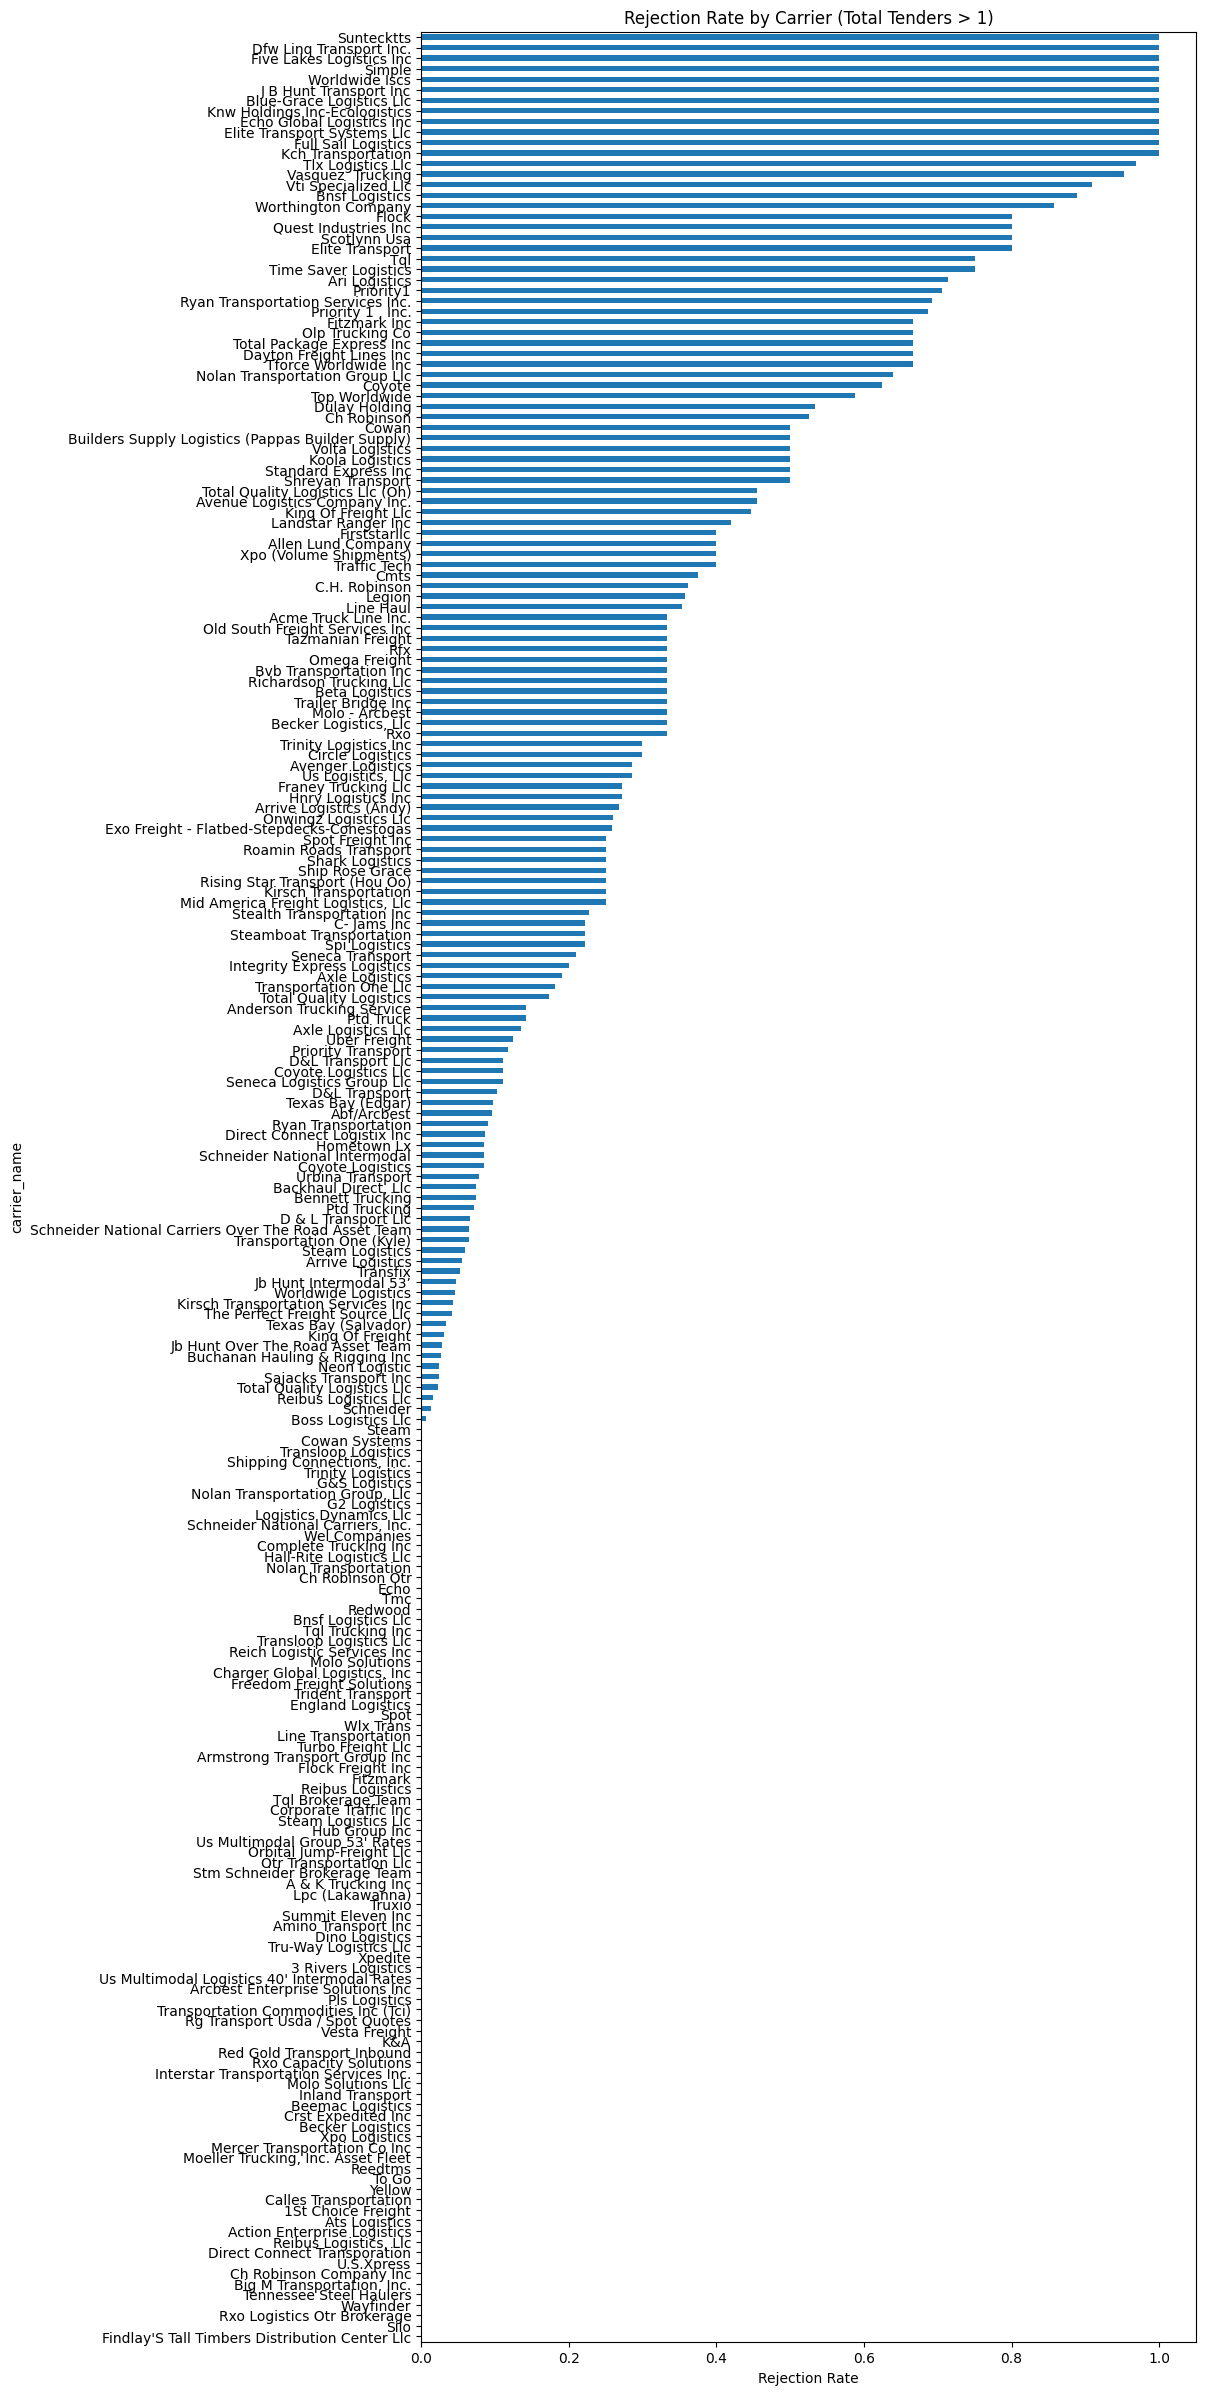

In [16]:
tdf["total_tenders"] = (
    tdf["rate_carrier_name_accepted"] + tdf["rate_carrier_name_rejected"]
)
tdf["rejection_rate"] = tdf["rate_carrier_name_rejected"] / (tdf["total_tenders"])

ax = (
    tdf.loc[tdf["total_tenders"] > 1, "rejection_rate"]
    .sort_values()
    .plot.barh(figsize=(10, 30), title="Rejection Rate by Carrier (Total Tenders > 1)")
)

ax.set_xlabel("Rejection Rate")

As we can see, most carriers always accept tender, but some carriers don't.

Unfortunately, just adding carrier names is a bad idea because:

- It'll bias the model to the carriers that are already in the dataset
- It won't generalize to new carriers
- It might take the effect of other features that can be generalized and unbiased

For the cases of serial rejection of a carrier, a simple Carrier Score Card might be more useful than a model.


Text(0.5, 0, 'Rejection Rate')

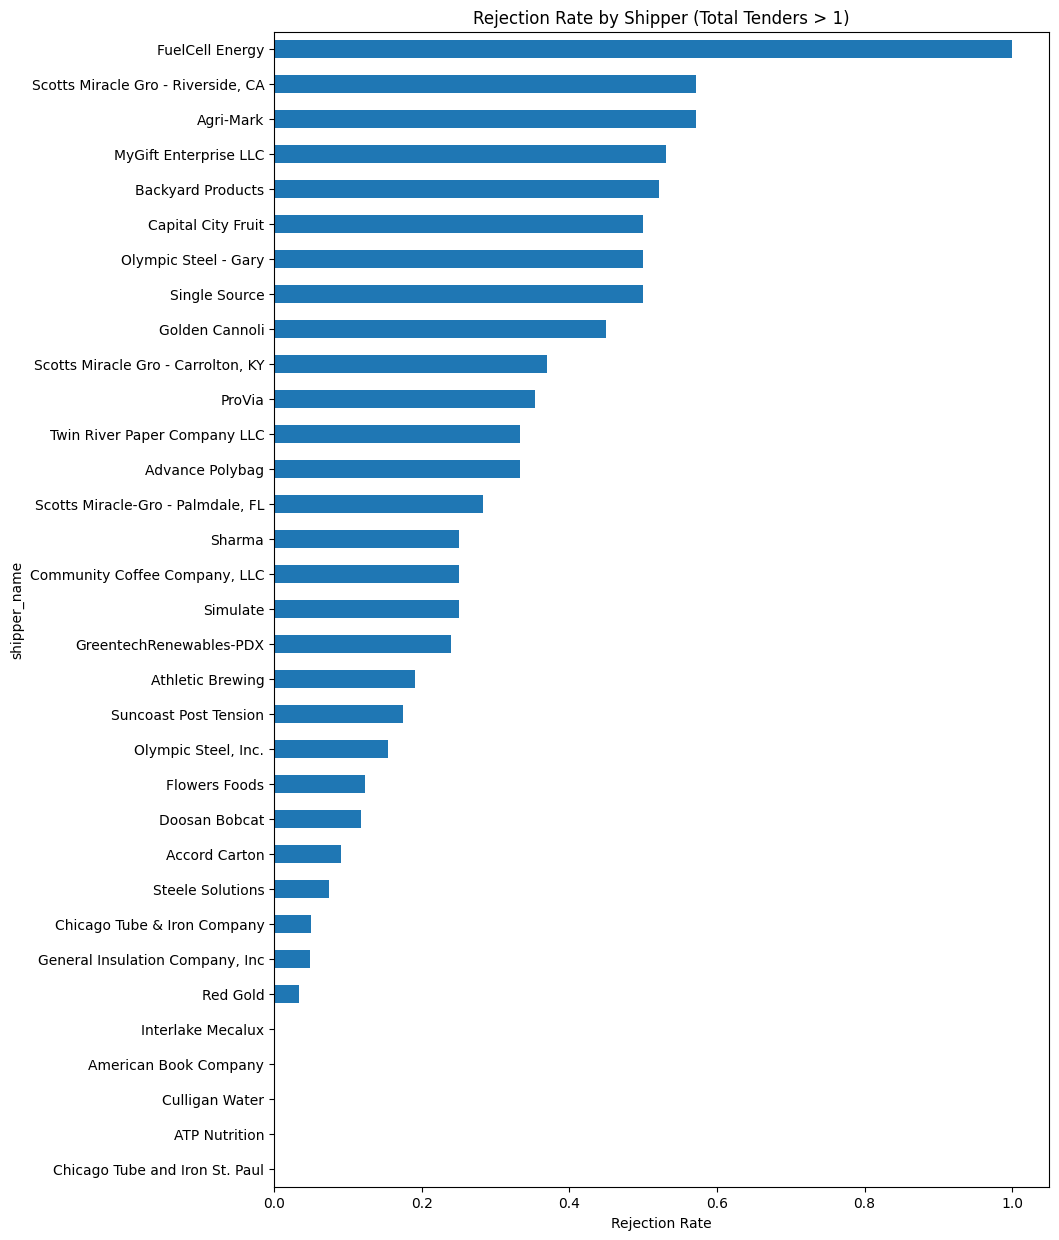

In [17]:
rejections = pd.DataFrame(df.loc[df.is_rejection & mask, "shipper"].value_counts())
# rejections["tender_type"] = "rejected"

rejections.index.name = "shipper_name"
acceptances = pd.DataFrame(df.loc[(~df.is_rejection) & mask, "shipper"].value_counts())
# acceptances["tender_type"] = "accepted"
acceptances.index.name = "shipper_name"
tdf = pd.merge(
    rejections,
    acceptances,
    how="outer",
    on="shipper_name",
    suffixes=("_rejected", "_accepted"),
).fillna(0.0)
tdf["total_tenders"] = tdf["shipper_accepted"] + tdf["shipper_rejected"]
tdf["rejection_rate"] = tdf["shipper_rejected"] / (tdf["total_tenders"])

ax = (
    tdf.loc[tdf["total_tenders"] > 1, "rejection_rate"]
    .sort_values()
    .plot.barh(figsize=(10, 15), title="Rejection Rate by Shipper (Total Tenders > 1)")
)

ax.set_xlabel("Rejection Rate")

We can also see that a few shippers have rejection on almost 50% of the tenders.

We might want to take a closer look at them to see if there's something wrong with the shipper or not.


## Analyzing some variables


In [18]:
df["rpm"] = df["flat_rate"] / df["mileage"]
df["rate_over_ls"] = df["flat_rate"] / df["ls_rate"]
df["rate_over_avg"] = df["flat_rate"] / df["avg_rates"]

df["is_loadsmart"] = df["rate_carrier_name"].str.lower().str.contains("loadsmart")

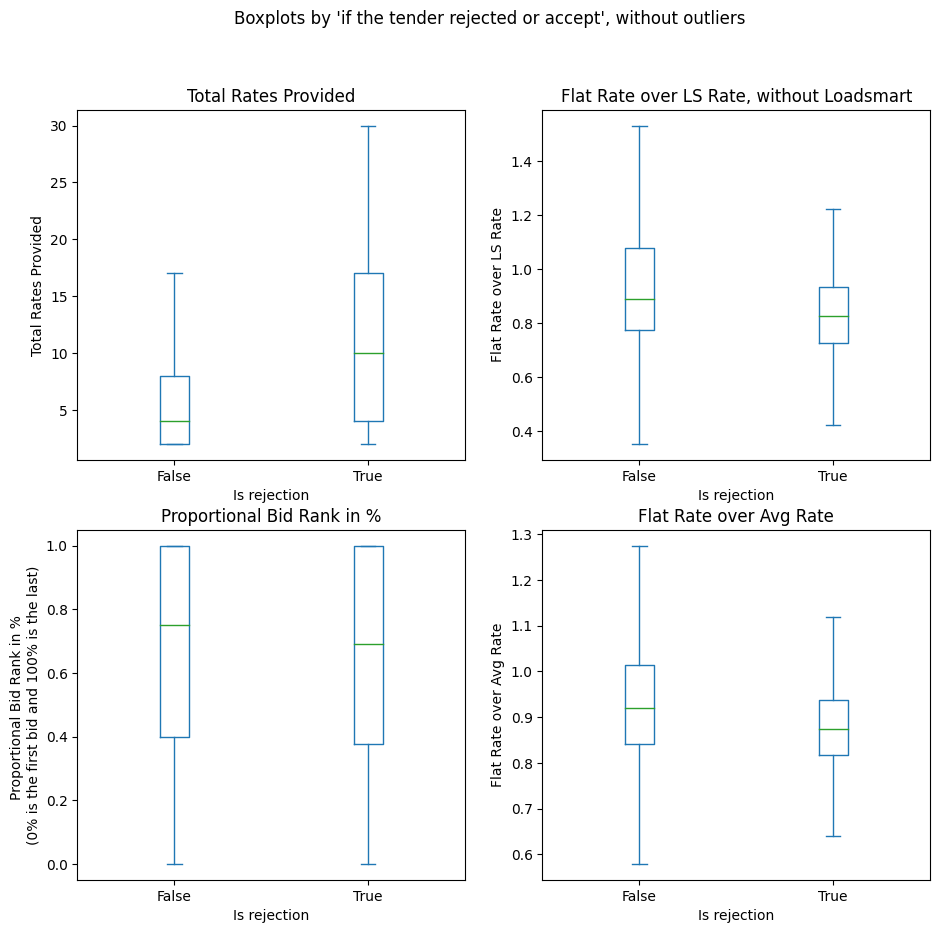

In [19]:
from utils import plot_boxplots

mask2 = (
    df["tender_status"].notnull()
    & (df["flat_rate"] > 1)
    & (df.tender_type.isin(["agnostic"]))
    & (df.total_rates_provided > 1)
)
plot_boxplots(df, mask2)

Looking at the blox plots, we can see that the lowest rates are :

1. slightly more skewed to the earliest bids
2. Lower than LS rates, with a median at 80% of LS Rates
3. Lower than the avg rates, with a median of under 90% of the avg rate


## Making features

### Quote related

The features below are related to:

- Location
- Pickup and delivery times


In [20]:
data = df.reset_index(drop=True)

In [21]:
data.shape

(132385, 74)

In [22]:
from utils import (
    geo_features,
    date_features,
    datetime_to_features,
    lead_time_features,
    rate_features,
    rejection_features,
)

data = geo_features(data)
data = date_features(data)
data = datetime_to_features(data, "pickup_date")
data = datetime_to_features(data, "delivery_date")
data = datetime_to_features(data, "sqr_quote_created")
data.shape

(132385, 124)

In [23]:
data = lead_time_features(data)
data.shape

(132385, 127)

### Bid related

The features below are related to the bid/rate, they include:

- Time of the bid (rate time) and leadtime
- Bid price and past bid prices and volumes for the quote


In [24]:
data = datetime_to_features(data, "rate_date")
data = lead_time_features(data, is_tender=True)
data.shape

(132385, 142)

In [25]:
data = data.reset_index(drop=True)
data = rate_features(data)
data.shape

(130150, 152)

In [26]:
mask = (
    data["tender_status"].notnull()
    & (data["flat_rate"] > 1)
    & (data["tender_type"].isin(["agnostic"]))
    & (~data["is_loadsmart"])
)

In [27]:
data = data[mask].copy(deep=True)
data.shape

(5640, 152)

### Tender related

These features will only work at the time of tender or based on carriers with
past tenders


In [28]:
data = datetime_to_features(data, "tender_sent_at")
data = rejection_features(data)
data.shape

(5640, 178)

In [29]:
data.to_parquet("data/tender_features.parquet")

In [30]:
data.loc[
    data["rate_carrier_id"] == 2988,
    ["rate_date", "rate_id", "is_rejection_mean", "tender_status", "is_rejection"],
]

,rate_date,rate_id,is_rejection_mean,tender_status,is_rejection
3834,2023-05-26 15:23:28.768,1592908,1.0,sent,1
4693,2023-06-06 14:30:53.044,1662196,1.0,sent,1
367,2023-07-06 16:56:44.859,2066638,1.0,accepted,0
4888,2023-05-09 19:19:44.118,1454943,1.0,sent,1
2832,2023-04-10 18:55:07.193,1276535,NaN,sent,1


In [31]:
print(
    f"Only {data['is_rejection_mean'].isnull().value_counts()[1]} of {len(data)} have past carrier tender information.\n"
    f"A model based on past rejection would only have a coverage of about {round(data['is_rejection_mean'].isnull().value_counts()[1]/len(data)*100,2)}%."
)

Only 378 of 5640 have past carrier tender information.
A model based on past rejection would only have a coverage of about 6.7%.


Text(0.5, 0, 'Carrier has past tender info')

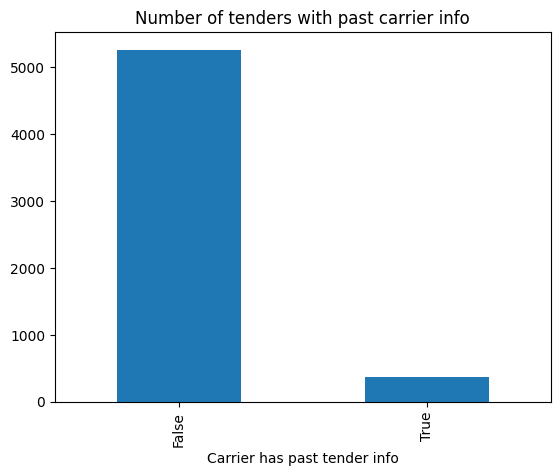

In [32]:
data["is_rejection_mean"].isnull().value_counts().plot.bar(
    title="Number of tenders with past carrier info"
).set_xlabel("Carrier has past tender info")

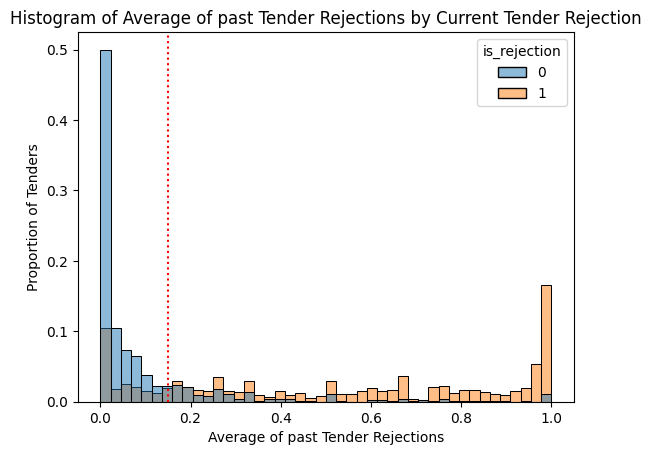

In [33]:
import seaborn as sns

ax = sns.histplot(
    data,
    x="is_rejection_mean",
    hue="is_rejection",
    kde=False,
    stat="proportion",
    common_norm=False,
)
ax.set_title(
    "Histogram of Average of past Tender Rejections by Current Tender Rejection"
)
ax.set_xlabel("Average of past Tender Rejections")
ax.set_ylabel("Proportion of Tenders")
plt.axvline(x=0.15, color="r", linestyle="dotted", label="axvline - full height")

# data[["is_rejected","is_rejection_mean"]].hist(title="Histogram of Average of past Tender Rejections")

The dotted line above shows an approximate point of 15% where we could set a threshold for a business metric:

- If the carrier has rejected over 15% of past tenders, we could consider them to be a high risk for rejection in the future.
- If not we can consider them a low risk.

It's important to see that this isn't a very good metric, as there's very low coverage and there are cases with low past rejection rates that do reject.

Is 15% too low of a cutting point? It depends! Historically and analytically it makes sense, since we can see that
the proportion of tender acceptance (blue bars) decreases as we look into carriers that have rejected more than 15% of the tenders in the past.

We can also pull some historical numbers, such as the average tender rejection hovers around 4% according to SONAR, and the
total tender rejection in ShipperGuide sits around 20%.


Text(0, 0.5, 'Proportion of Tenders')

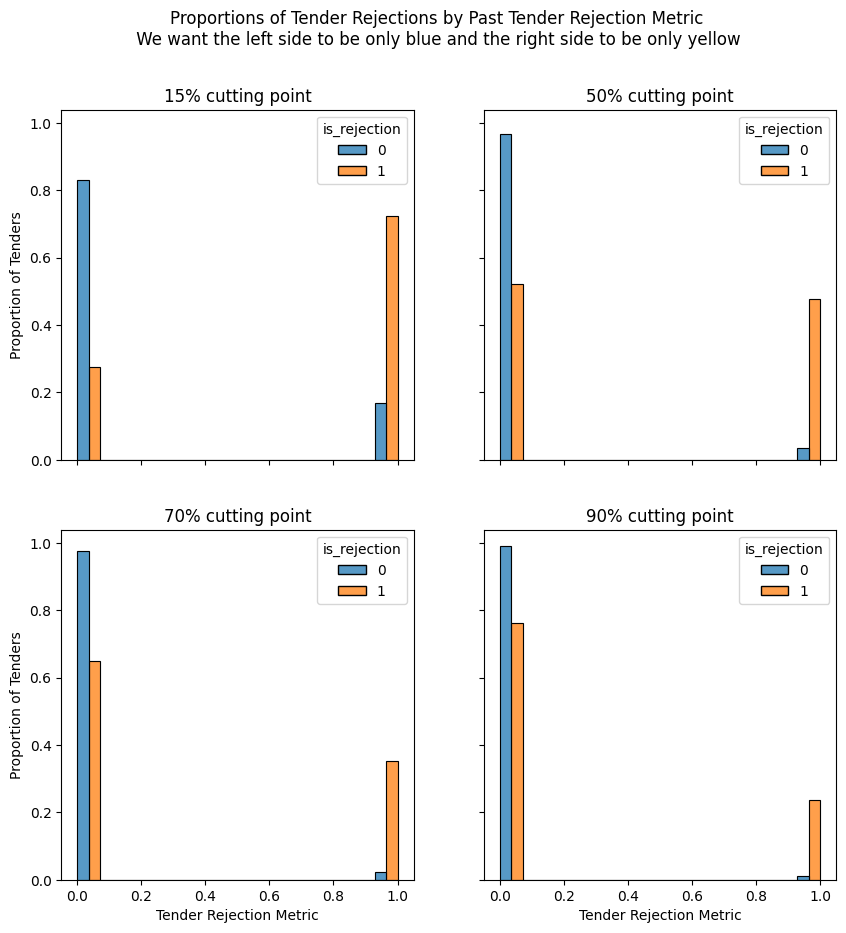

In [34]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)

sns.histplot(
    data,
    x="is_rejection_mean_15",
    hue="is_rejection",
    kde=False,
    stat="proportion",
    common_norm=False,
    multiple="dodge",
    ax=axes[0, 0],
)
axes[0, 0].set_title("15% cutting point")

sns.histplot(
    data,
    x="is_rejection_mean_50",
    hue="is_rejection",
    kde=False,
    stat="proportion",
    multiple="dodge",
    common_norm=False,
    ax=axes[0, 1],
)
axes[0, 1].set_title("50% cutting point")

sns.histplot(
    data,
    x="is_rejection_mean_70",
    hue="is_rejection",
    kde=False,
    stat="proportion",
    multiple="dodge",
    common_norm=False,
    ax=axes[1, 0],
)
axes[1, 0].set_title("70% cutting point")

sns.histplot(
    data,
    x="is_rejection_mean_90",
    hue="is_rejection",
    kde=False,
    stat="proportion",
    multiple="dodge",
    common_norm=False,
    ax=axes[1, 1],
)
axes[1, 1].set_title("90% cutting point")


fig.suptitle(
    "Proportions of Tender Rejections by Past Tender Rejection Metric\n We want the left side to be only blue and the right side to be only yellow"
)
axes[1, 0].set_xlabel("Tender Rejection Metric")
axes[0, 0].set_ylabel("Proportion of Tenders")

axes[1, 1].set_xlabel("Tender Rejection Metric")
axes[1, 0].set_ylabel("Proportion of Tenders")

# data[["is_rejected","is_rejection_mean"]].hist(title="Histogram of Average of past Tender Rejections")

The graph below show us that whenever the blue bar is in the left, we have True Negatives Rate (TNR), and whenever the blue bar is in the right, we have False Positives Rate (FPR). The orange bar in the left is the False Negatives Rate (FNR) and when the orange bar is in the right it's the True Positives Rate (TPR).

The sum of same colored bars will give 100%.

The graphs above shows us that increasing the cutting point will drastically reduce the cases of FPR and increase FNR.
Finding the best cutting point becomes a trade-off between FPR and FNR, which is a classic problem of classification.

One interesting thing to analyze is that just a small past average tender rejection has a huge impact in the
likelihood of the tender being rejected again by the same carrier.


## Last Words

The features created above are the same as the first analysis, in the end I just filter to look at only the tenders.

The problem with tenders is that rejections are a very rare occurrence and we can't simply use past carrier rejection
as a proxy, since we most likely won't have that information.

A few features we can add:

- Carrier information such as headquarters location, onboarding and so on
- Cross it with patterns of rejection
- See if the carrier is a broker or not
